In [20]:
library(fda)
library(purrr)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(mvtnorm)
library(IRdisplay)
library(lubridate)
library(tidyverse)

source("../helpers.R")

## 2.1 Derivatives

In [22]:
matern_cov = function(d_mat, nu, rho=1, sigma=1){
    a = sqrt(2*nu) * d_mat / rho
    cov = (sigma**2) * (2**(1-nu)) / gamma(nu) * (a**nu) * besselK(a, nu)
    cov[d_mat==0] = 0.000001
    cov[a>0] = cov[a>0] * exp(-sqrt(2 * nu) * a[a > 0] / rho)
    return(cov)
}

In [23]:
set.seed(123)
n_sims = 1
t_grid = seq(0, 1, length.out=100)
dist = as.matrix(dist(t_grid))
params = c(0.5, 1, 1)

nu = params[1]
sigma = params[2]
rho = params[3]

cov_matrix = matern_cov(dist, nu, rho, sigma)

matern_iid = rmvnorm(n_sims, rep(0, length(t_grid)), cov_matrix)
matern_iid = matern_iid[1,]

df = data.frame(t = t_grid, y = matern_iid)

B25_basis= create.bspline.basis(rangeval=c(0, 1), nbasis=50)
Matern_fd = smooth.basis(argvals=t_grid, y=matern_iid, fdParobj=B25_basis)

smoothed_values <- eval.fd(t_grid, Matern_fd$fd)

df$smoothed = smoothed_values

Warning message in rmvnorm(n_sims, rep(0, length(t_grid)), cov_matrix):
"sigma is numerically not positive semidefinite"


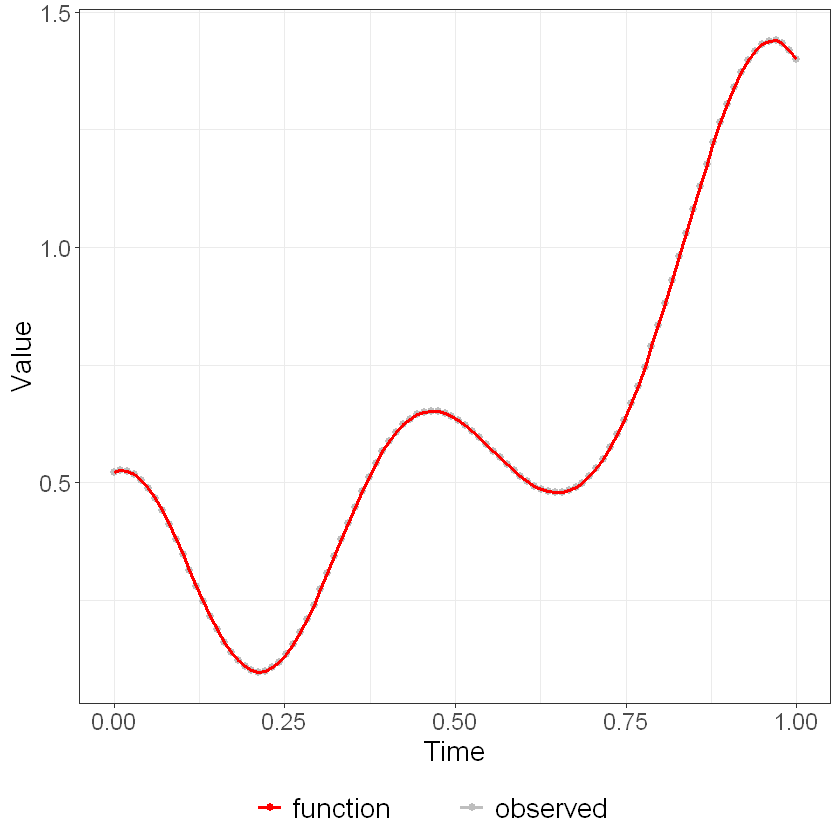

In [26]:
p = ggplot(df, aes(x=t)) +
    geom_point(aes(y = y, colour = 'observed'), size = 2) + 
    geom_line(aes(y = smoothed, colour = 'function'), size = 1) +
    xlab("Time") +
    ylab("Value") +  
    mytheme +
    scale_color_manual(
        labels  = legend_pad,
        values = c("observed" = "gray", "function" = "red"),    
    ) 

print(p)
ggsave("./images/211_matern.png", plot = p, width = 480/96, height = 520/96, dpi = 96)



In [25]:
deriv_observed = matrix(0, nrow = 1, ncol = length(matern_iid)-1)

for (i in 1:length(matern_iid)-1){
    a = matern_iid[i+1] - matern_iid[i]
    deriv = a / 0.01
    deriv_observed[i]=deriv
}

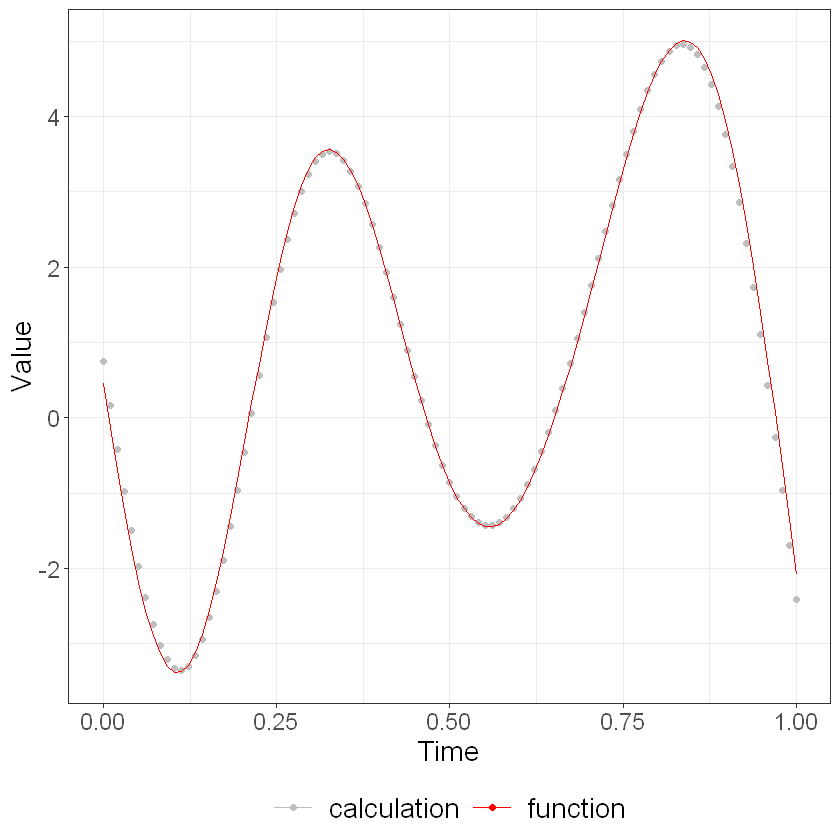

In [253]:
df = data.frame(
  t = seq(0, 1, length.out = 99),
  y = eval.fd(seq(0, 1, length.out = 99), deriv1_Matern_fd),
  deriv_observed = t(deriv_observed)
)

p = ggplot(df, aes(x = t)) +
  geom_point(aes(y = rep1, colour="calculation")) +
  geom_line(aes(y = deriv_observed, colour = "function")) +
  xlab("Time") +
  ylab("Value") +  
  mytheme +
  scale_color_manual(
        labels  = str_pad_custom,
        values = c("calculation" = "gray", "function" = "red"),    
    ) +
    theme(
        legend.title = element_blank(), 
        legend.key.width = unit(1.0,  unit = "cm"),
        legend.spacing.x = unit(0.25, unit = "cm")
    ) 

print(p)
ggsave("./images/212_deriv_matern.png", plot = p, width = 480/96, height = 520/96, dpi = 96)



---

# 2.2  Penalized smoothing

In [364]:
sample_temp = read.csv("sample_temp.csv", header=FALSE,skip=5)
head(sample_temp)

,V1,V2,V3,V4
,<chr>,<dbl>,<int>,<int>
1,2023/5/16 1:00:00,13.1,8,1
2,2023/5/16 2:00:00,13.5,8,1
3,2023/5/16 3:00:00,13.1,8,1
4,2023/5/16 4:00:00,12.4,8,1
5,2023/5/16 5:00:00,12.7,8,1
6,2023/5/16 6:00:00,13.6,8,1


In [366]:
sample_temp = sample_temp[,c( -3,-4)]
sample_temp = sample_temp[-nrow(sample_temp),]
colnames(sample_temp)= c("datetime", "temp")
head(sample_temp)

,datetime,temp
,<chr>,<dbl>
1,2023/5/16 1:00:00,13.1
2,2023/5/16 2:00:00,13.5
3,2023/5/16 3:00:00,13.1
4,2023/5/16 4:00:00,12.4
5,2023/5/16 5:00:00,12.7
6,2023/5/16 6:00:00,13.6


In [367]:
sample_temp$datetime = ymd_hms(sample_temp$datetime)
sample_temp$date = date(sample_temp$datetime)
sample_temp$time = hour(sample_temp$datetime)

In [368]:
head(sample_temp)

,datetime,temp,date,time
,<dttm>,<dbl>,<date>,<int>
1,2023-05-16 01:00:00,13.1,2023-05-16,1
2,2023-05-16 02:00:00,13.5,2023-05-16,2
3,2023-05-16 03:00:00,13.1,2023-05-16,3
4,2023-05-16 04:00:00,12.4,2023-05-16,4
5,2023-05-16 05:00:00,12.7,2023-05-16,5
6,2023-05-16 06:00:00,13.6,2023-05-16,6


In [369]:
sample_temp = sample_temp[-24,]

In [370]:
head(sample_temp)

,datetime,temp,date,time
,<dttm>,<dbl>,<date>,<int>
1,2023-05-16 01:00:00,13.1,2023-05-16,1
2,2023-05-16 02:00:00,13.5,2023-05-16,2
3,2023-05-16 03:00:00,13.1,2023-05-16,3
4,2023-05-16 04:00:00,12.4,2023-05-16,4
5,2023-05-16 05:00:00,12.7,2023-05-16,5
6,2023-05-16 06:00:00,13.6,2023-05-16,6


In [371]:
df1 = sample_temp[1:(nrow(sample_temp)/2), ]
df2 = sample_temp[(nrow(sample_temp)/2+1):nrow(sample_temp), ]

In [372]:
head(df1)
head(df2)

,datetime,temp,date,time
,<dttm>,<dbl>,<date>,<int>
1,2023-05-16 01:00:00,13.1,2023-05-16,1
2,2023-05-16 02:00:00,13.5,2023-05-16,2
3,2023-05-16 03:00:00,13.1,2023-05-16,3
4,2023-05-16 04:00:00,12.4,2023-05-16,4
5,2023-05-16 05:00:00,12.7,2023-05-16,5
6,2023-05-16 06:00:00,13.6,2023-05-16,6


,datetime,temp,date,time
,<dttm>,<dbl>,<date>,<int>
25,2023-05-17 01:00:00,13.4,2023-05-17,1
26,2023-05-17 02:00:00,12.8,2023-05-17,2
27,2023-05-17 03:00:00,12.3,2023-05-17,3
28,2023-05-17 04:00:00,11.7,2023-05-17,4
29,2023-05-17 05:00:00,11.9,2023-05-17,5
30,2023-05-17 06:00:00,13.7,2023-05-17,6


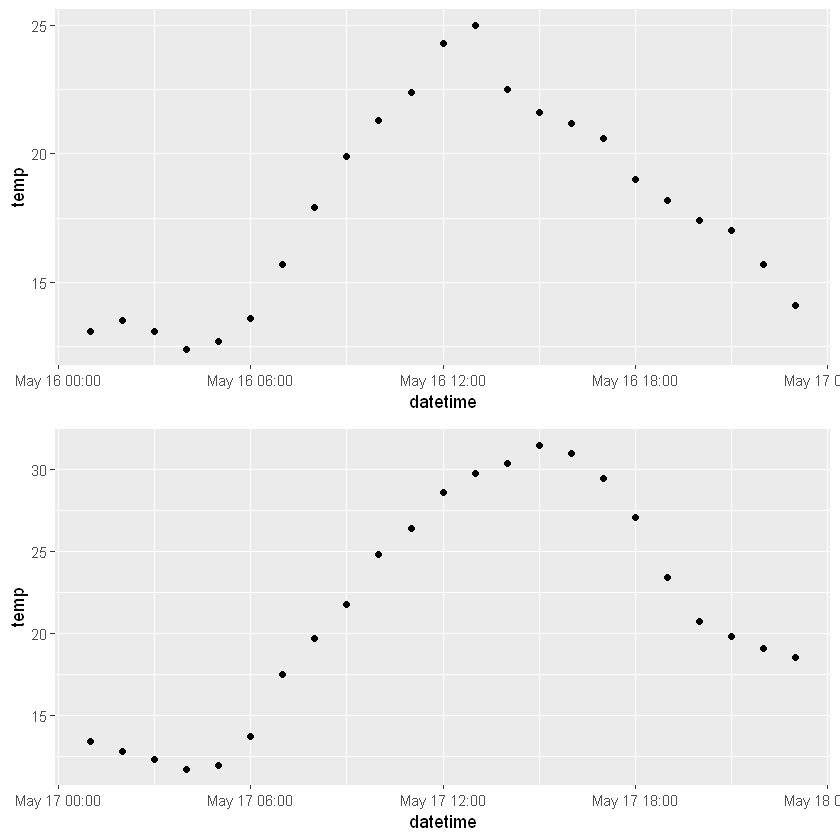

In [373]:
p1 = ggplot(df1, aes(x=datetime))+
    geom_point(aes(y=temp))

p2 = ggplot(df2, aes(x=datetime))+
    geom_point(aes(y=temp))

grid.arrange(p1,p2, ncol=1)

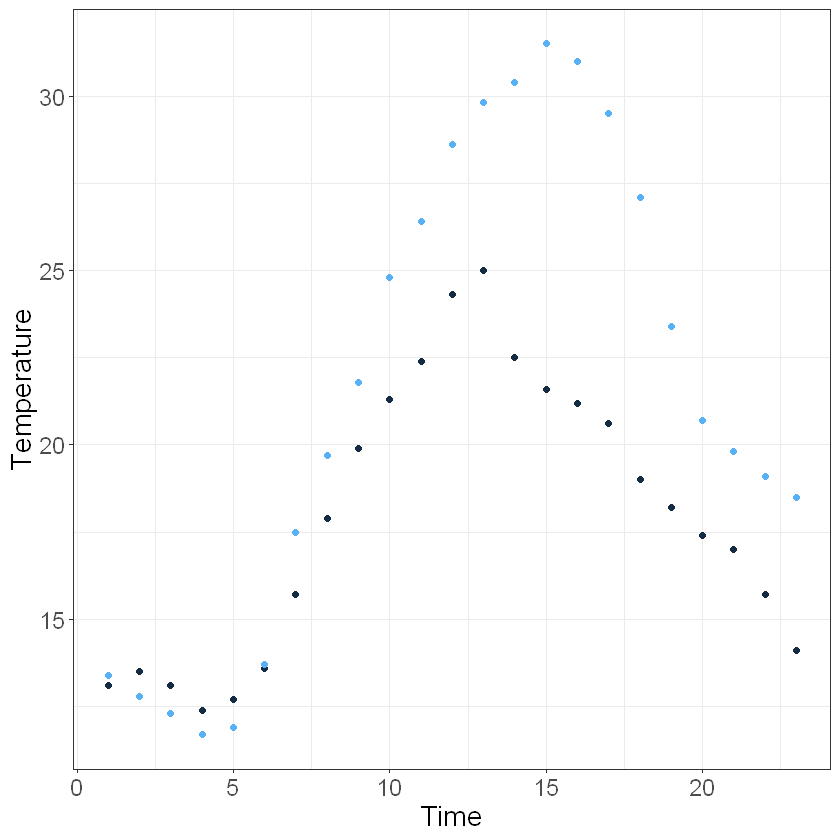

In [419]:
p = ggplot(sample_temp, aes(x=time))+
    geom_point(aes(y=temp, color=date))+
    xlab("Time") + 
    ylab("Temperature") +
    mytheme + 
    guides(color=FALSE)

print(p)
ggsave("./images/221_sample_temp.png", plot = p, width = 500/96, height = 500/96, dpi = 96)

## Matern process

In [408]:
set.seed(123)
t_grid = seq(0, 1, length.out=100)
dist = as.matrix(dist(t_grid))
params = c(2.5, 1, 1)

nu = params[1]
sigma = params[2]
rho = params[3]

cov_matrix = matern_cov(dist, nu, rho, sigma)
matern_iid = t(rmvnorm(1, rep(0, length(t_grid)), cov_matrix))
B25_basis= create.bspline.basis(rangeval=c(0, 1), nbasis=25)
matern_fd = smooth.basis(argvals=t_grid, y=matern_iid, fdParobj=B25_basis)
smoothed_value = eval.fd(t_grid, matern_fd$fd)

matern_fd

Warning message in rmvnorm(1, rep(0, length(t_grid)), cov_matrix):
"sigma is numerically not positive semidefinite"


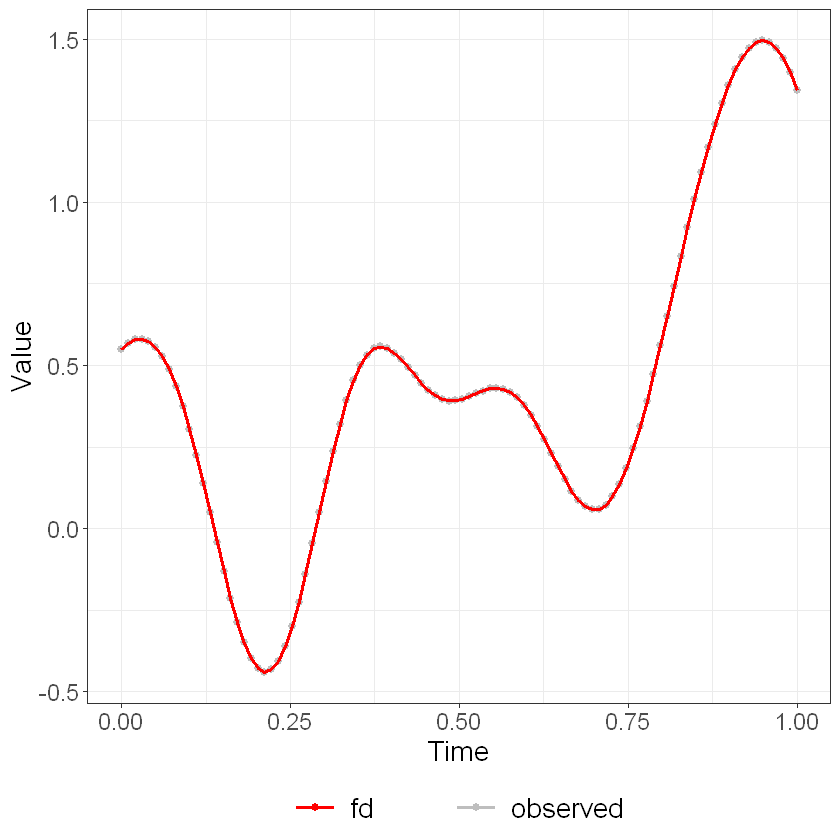

In [421]:
df = data.frame(
    time=t_grid,
    observed=matern_iid,
    fd = smoothed_value
)

p = ggplot(df, aes(x=time))+
    geom_point(aes(y=observed, color="observed"), size=2) + 
    geom_line(aes(y=fd, color="fd"), size=1)+
    xlab("Time") + 
    ylab("Value") +
    scale_color_manual(
        labels  = str_pad_custom,
        values = c("observed" = "gray", "fd" = "red"),    
    ) +
    mytheme+
    theme(
        legend.title = element_blank(), 
        legend.key.width = unit(1.0,  unit = "cm"),
        legend.spacing.x = unit(0.25, unit = "cm")
    ) 
    
print(p)

ggsave("./images/2212_matern.png",  plot = p, width = 480/96, height = 520/96, dpi = 96)

### $\lambda$の計算 (GCV)

In [27]:
Lcoef = c(0, 0, 1)
Lfd= vec2Lfd(Lcoef, c(0,1))


### peneralized

In [ ]:

lambda = 
fdParobj =fdPar(daybasis, harmaccelLfd, lambda)

## CanadianWeather

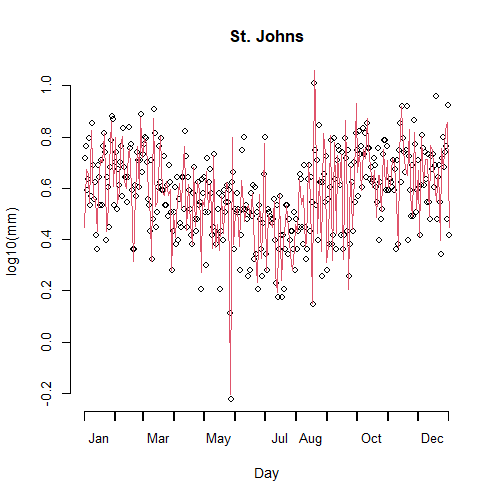

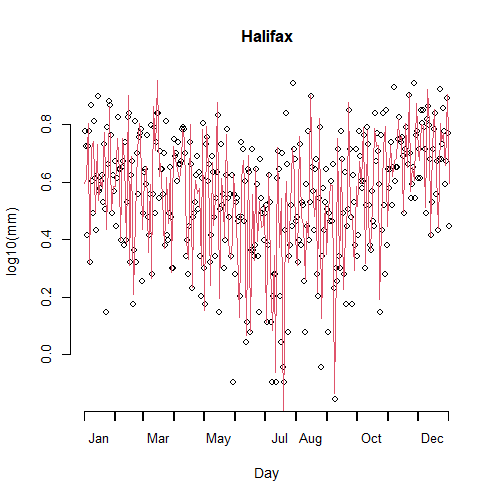

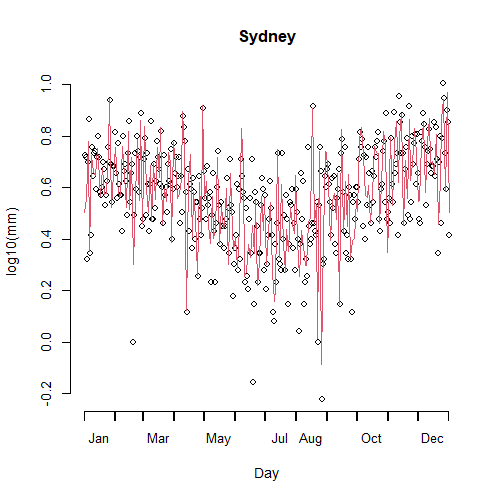

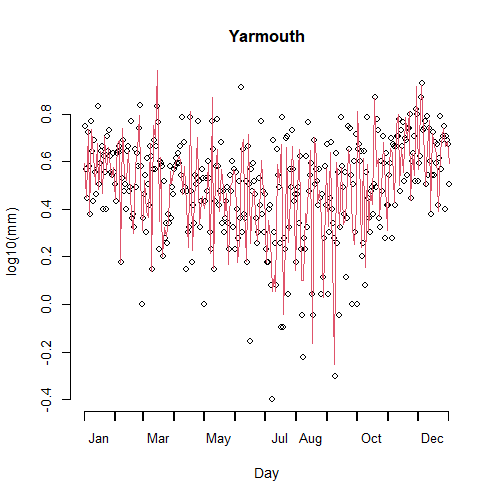

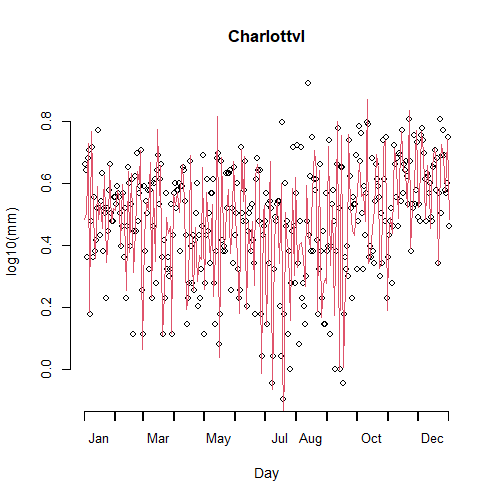

In [424]:
nbasis=365
yearRng = c(0, 365)
daybasis = create.fourier.basis(yearRng, nbasis)
logprecav = CanadianWeather$dailyAv[,,'log10precip']
dayprecfd = with(CanadianWeather, smooth.basis(day.5, logprecav, daybasis, fdnames=list("Day", "Station", "log10(mm)"))$fd)
for(i in 1:5){
    pngname=paste0("./images/22",i+1,"_canadatemp", i,".png")
    png(pngname, width=500, height = 500) 
    par(cex=1.2)
    plot(logprecav[,i], axes=FALSE, xlab="Day", ylab="log10(mm)", main=CanadianWeather$place[i])
    lines(dayprecfd[i], col=2)
    axisIntervals(1)
    axis(2)

    dev.off()
    png_data <- readBin(pngname, "raw", file.size(pngname))
    display_png(png_data)

}

In [430]:
Lcoef = c(0, (2*pi/diff(yearRng))**2, 0, 1)
harmaccelLfd= vec2Lfd(Lcoef, yearRng)

In [432]:
loglam = 4:9
nlam = length(loglam)
dfsave = rep(NA, nlam)
names(dfsave) = loglam
gcvsave = dfsave
for (ilam in 1:nlam) {
    cat(paste("log10 lambda =", loglam[ilam],'\n'))
    lambda = 10**loglam[ilam]
    fdParobj = fdPar(daybasis, harmaccelLfd, lambda)
    smoothlist = smooth.basis(day.5, logprecav, fdParobj)
    dfsave[ilam] = smoothlist$df
    gcvsave[ilam] = sum(smoothlist$gcv)
}



log10 lambda = 4 
log10 lambda = 5 
log10 lambda = 6 
log10 lambda = 7 
log10 lambda = 8 
log10 lambda = 9 


Warning message in smooth.basis1(argvals, y, fdParobj, wtvec = wtvec, fdnames = fdnames, :
"lambda reduced to 389800616.78291 to prevent overflow"


png 
  2

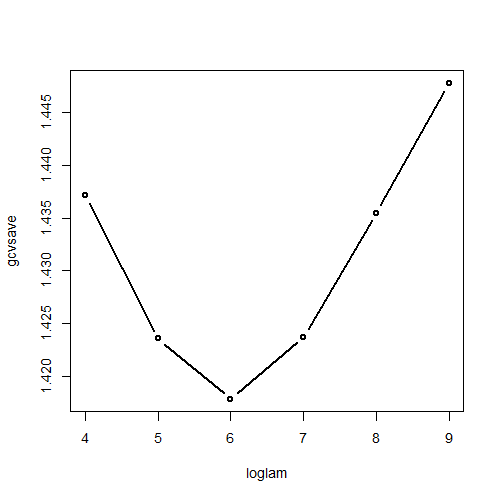

In [434]:
png("./images/2215_canada_gcv.png", width=500, height = 500) 
par(cex=1.2)

plot(loglam,gcvsave, type='b', lwd=2)

dev.off()
png_data <- readBin("./images/2215_canada_gcv.png", "raw", file.size("./images/2215_canada_gcv.png"))
display_png(png_data)

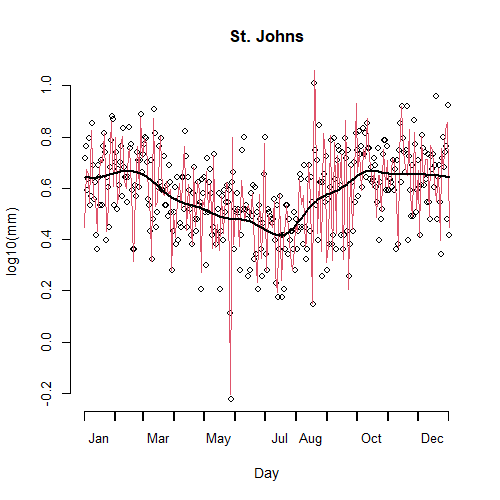

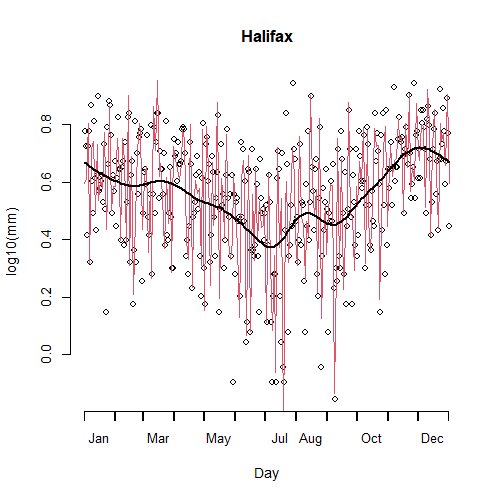

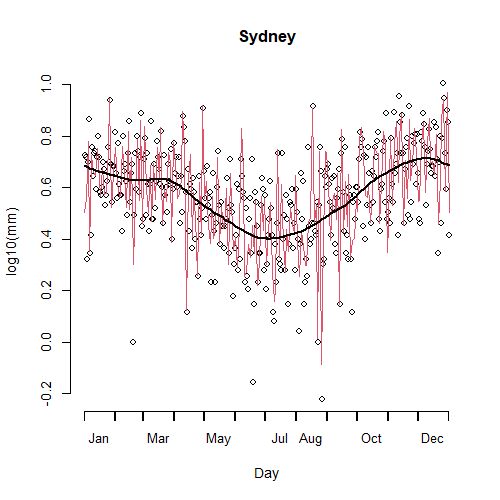

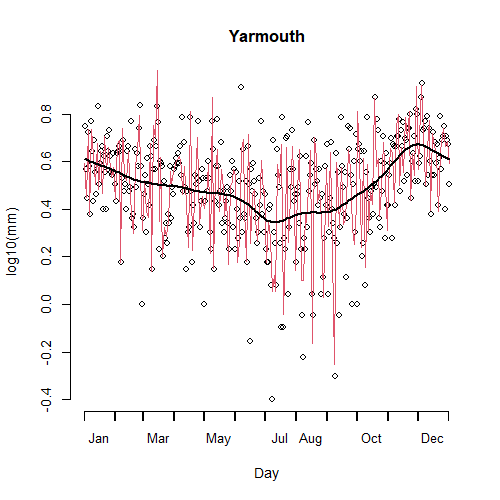

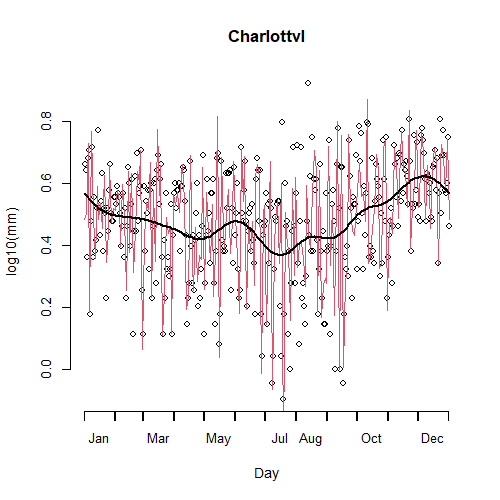

In [427]:
lambda = 1e6
fdParobj =fdPar(daybasis, harmaccelLfd, lambda)
logprec.fit = smooth.basis(day.5, logprecav, fdParobj)
logprec.fd = logprec.fit$fd
fdnames = list("Day (July 1 to June 30)", "Weather Station"=CanadianWeather$place, "Log 10 Precipitation(mm)")
logprec.fd$fdnames = fdnames

for(i in 1:5) {
    pngname=paste0("./images/22",i+6,"_canadatemp_penalize", i,".png")
    png(pngname, width=500, height = 500) 
    par(cex=1.2)
    
    plot(logprecav[,i], axes=FALSE, xlab="Day", ylab="log10(mm)", main=CanadianWeather$place[i])
    lines(dayprecfd[i], col=2)
    axisIntervals(1)
    axis(2)
    lines(logprec.fd[i], lwd=2)
    
    dev.off()
    png_data <- readBin(pngname, "raw", file.size(pngname))
    display_png(png_data)
}

# 2.3 Curve alignment

In [7]:
x = seq(0, 2*pi, length.out=100)
df = data.frame(x=x)

for(i in 1:5){
    df[paste("sin",i,sep="")] = sin(x + i*pi/4)
}

In [8]:
df_long = reshape2::melt(df, id="x")
head(df_long)
tail(df_long)

,x,variable,value
,<dbl>,<fct>,<dbl>
1,0.00000000,sin1,0.7071068
2,0.06346652,sin1,0.7505306
3,0.12693304,sin1,0.7909324
4,0.19039955,sin1,0.8281493
5,0.25386607,sin1,0.8620315
6,0.31733259,sin1,0.8924427


,x,variable,value
,<dbl>,<fct>,<dbl>
495,5.965853,sin5,-0.4511608
496,6.029319,sin5,-0.5068546
497,6.092786,sin5,-0.5605076
498,6.156252,sin5,-0.6119036
499,6.219719,sin5,-0.6608357
500,6.283185,sin5,-0.7071068


Your code contains a unicode char which cannot be displayed in your
current locale and R will silently convert it to an escaped form when the
R kernel executes this code. This can lead to subtle errors if you use
such chars to do comparisons. For more information, please see
https://github.com/IRkernel/repr/wiki/Problems-with-unicode-on-windows

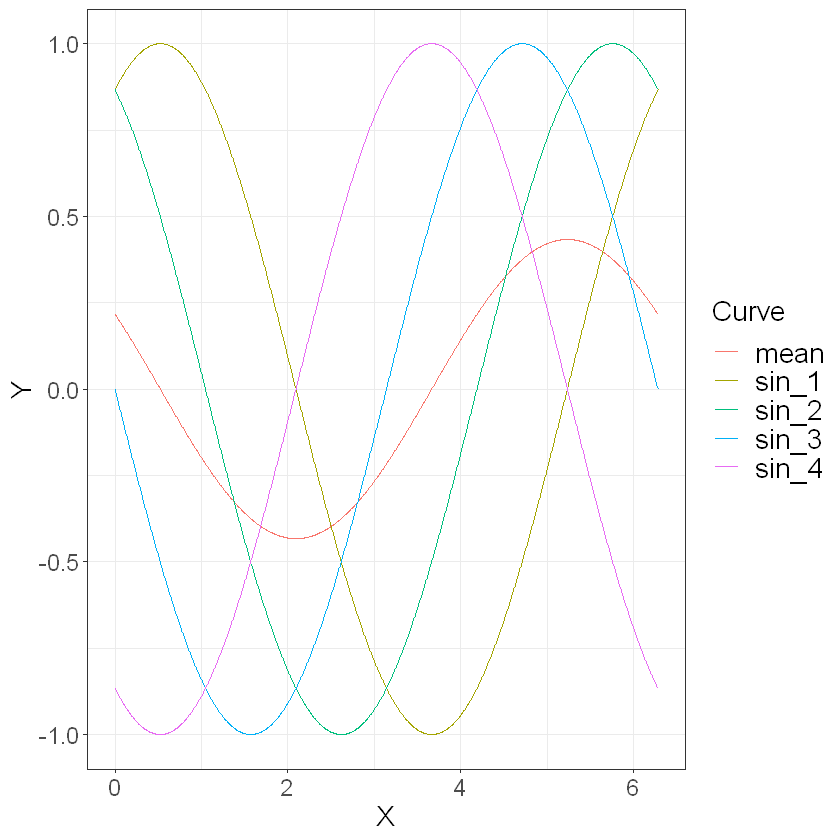

In [20]:


# データ生成
x = seq(0, 2*pi, length.out = 1000)
df = tibble(x = x)

# 各サインカーブの計算
df = df %>%
  bind_cols(map_dfc(1:4, ~ tibble(!!paste("sin_", ., sep="") := sin(x + . * pi/3))))

# データの整形
df_long = df %>%
  tidyr::pivot_longer(-x, names_to = "curve", values_to = "y")

# 平均関数の計算
fd_obj = create.bspline.basis(rangeval = range(x), nbasis = 100)
data_fd = Data2fd(argvals = x, y = as.matrix(df %>% select(starts_with("sin"))), basisobj = fd_obj)
mean_fd = mean.fd(data_fd)

# 平均関数の追加
df_long <- df_long %>%
  add_row(x = x, curve = "mean", y = eval.fd(x, mean_fd))

p = ggplot(df_long, aes(x=x, y=y, color=curve)) +
    geom_line() +
    labs(x="X", y="Y", color="Curve") +
    mytheme

print(p)
ggsave("./images/230_sine_curves.png", plot = p, width = 620/96, height = 500/96, dpi = 96)


In [23]:
growth

,boy01,boy02,boy03,boy04,boy05,boy06,boy07,boy08,boy09,boy10,...,boy30,boy31,boy32,boy33,boy34,boy35,boy36,boy37,boy38,boy39
1,81.3,76.2,76.8,74.1,74.2,76.8,72.4,73.8,75.4,78.8,...,74.9,74.2,78.7,78.0,76.0,76.0,68.8,82.2,77.0,75.0
1.25,84.2,80.4,79.8,78.4,76.3,79.1,76.0,78.7,81.0,83.3,...,78.7,78.3,83.3,82.6,81.2,80.1,73.5,88.9,82.5,79.2
1.5,86.4,83.2,82.6,82.6,78.3,81.1,79.4,83.0,84.9,87.0,...,81.0,82.3,87.0,85.8,84.6,85.9,77.5,90.9,85.6,82.2
1.75,88.9,85.4,84.7,85.4,80.3,84.4,82.0,85.8,87.9,89.6,...,84.9,86.0,90.4,88.4,87.0,91.4,80.8,93.0,87.9,84.6
2,91.4,87.6,86.7,88.1,82.2,87.4,84.2,88.4,90.0,91.4,...,87.7,89.1,93.1,90.9,89.1,95.2,84.0,95.3,90.3,87.0
3,101.1,97.0,94.2,98.6,89.4,94.0,93.2,97.3,97.3,100.4,...,93.2,97.1,103.0,99.1,94.6,103.5,95.2,103.8,98.3,95.8
4,109.5,104.6,100.4,104.4,96.9,102.4,101.6,106.7,102.8,111.0,...,104.2,104.9,109.7,105.8,102.0,111.6,103.1,111.8,107.2,103.1
5,115.8,112.3,107.1,111.0,104.1,109.2,109.0,112.8,108.2,118.5,...,110.0,112.0,118.0,112.2,107.4,118.1,111.1,117.1,114.6,110.2
6,121.9,118.9,112.3,116.3,110.7,116.1,117.3,119.1,113.5,125.8,...,116.0,118.6,124.6,117.6,113.0,126.3,118.4,123.7,121.9,116.1
7,130.0,125.0,118.6,123.2,115.8,121.9,122.9,125.7,120.2,131.1,...,123.8,124.7,132.3,123.4,119.4,132.8,124.9,130.4,129.2,122.2


[1] "done"

png 
  2

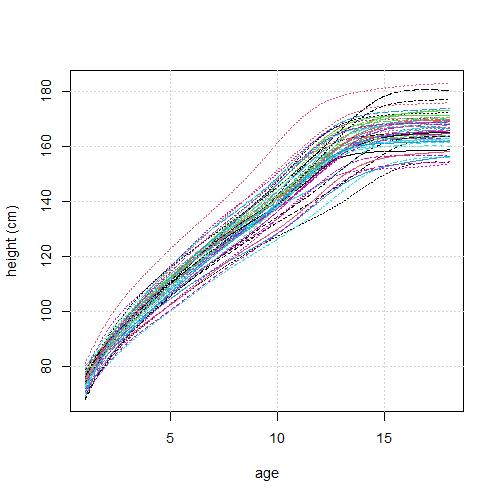

In [47]:
age = growth$age
heightBasis = create.bspline.basis(c(1,18), 35, 6, age)
heightPar = fdPar(heightBasis, 3, 10**(-0.5))
heightSmooth = smooth.basis(age, growth$hgtf, heightPar)

pngname=paste0("./images/231_growth.png")
png(pngname, width=500, height = 500)
par(cex=1.2)
plot(heightSmooth, lwd=1, xlab="age", ylab="height (cm)")
grid()

dev.off()
png_data <- readBin(pngname, "raw", file.size(pngname))
display_png(png_data)

In [40]:
heightSmooth$fd

$coefs
            girl01    girl02    girl03    girl04    girl05    girl06    girl07
bspl6.1   77.09197  75.26247  79.03451  77.67119  76.77177  74.41344  68.25921
bspl6.2   77.68513  76.03182  79.59601  78.31576  77.42472  75.04835  69.04396
bspl6.3   78.85648  77.53767  80.71023  79.58998  78.70902  76.29625  70.58783
bspl6.4   80.56860  79.69787  82.35524  81.45652  80.57065  78.10234  72.82682
bspl6.5   82.76164  82.38101  84.49596  83.85565  82.92319  80.37893  75.65847
bspl6.6   86.91264  87.22485  88.64117  88.41486  87.28638  84.58590  80.91625
bspl6.7   92.08151  92.66291  94.04278  94.11134  92.48978  89.57569  87.19764
bspl6.8   97.83294  97.66923 100.55188 100.37699  97.85035  94.72942  93.64634
bspl6.9  104.07365 102.60835 108.46202 106.96084 103.37214 100.17095  99.86107
bspl6.10 110.78064 108.85010 116.44009 114.03575 109.88302 106.61234 106.14655
bspl6.11 116.82707 115.58528 122.75663 120.37641 116.74172 112.90953 112.06499
bspl6.12 121.70778 121.61609 127.64791 125.35

In [35]:
heightSmooth

$fd
$coefs
            girl01    girl02    girl03    girl04    girl05    girl06    girl07
bspl6.1   77.09197  75.26247  79.03451  77.67119  76.77177  74.41344  68.25921
bspl6.2   77.68513  76.03182  79.59601  78.31576  77.42472  75.04835  69.04396
bspl6.3   78.85648  77.53767  80.71023  79.58998  78.70902  76.29625  70.58783
bspl6.4   80.56860  79.69787  82.35524  81.45652  80.57065  78.10234  72.82682
bspl6.5   82.76164  82.38101  84.49596  83.85565  82.92319  80.37893  75.65847
bspl6.6   86.91264  87.22485  88.64117  88.41486  87.28638  84.58590  80.91625
bspl6.7   92.08151  92.66291  94.04278  94.11134  92.48978  89.57569  87.19764
bspl6.8   97.83294  97.66923 100.55188 100.37699  97.85035  94.72942  93.64634
bspl6.9  104.07365 102.60835 108.46202 106.96084 103.37214 100.17095  99.86107
bspl6.10 110.78064 108.85010 116.44009 114.03575 109.88302 106.61234 106.14655
bspl6.11 116.82707 115.58528 122.75663 120.37641 116.74172 112.90953 112.06499
bspl6.12 121.70778 121.61609 127.64791 12

[1] "done"

png 
  2

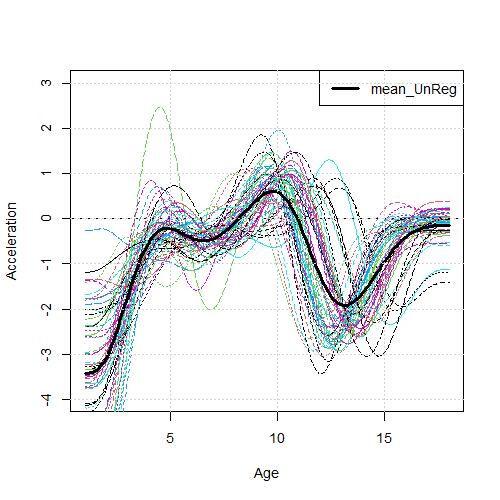

In [70]:
accelUnreg = deriv.fd(heightSmooth$fd, 2)
mean_accelUnreg = mean.fd(accelUnreg)

pngname=paste0("./images/232_growth_accel.png")
png(pngname, width=500, height = 500)
par(cex=1.2)

plot(accelUnreg[,1], lwd=1, xlab="Age", ylab="Acceleration", ylim=c(-4,3))
lines(mean_accelUnreg, lwd=3, col="black")
legend("topright", legend="mean_UnReg", lty=1, lwd=3, col="black")
grid()

dev.off()
png_data <- readBin(pngname, "raw", file.size(pngname))
display_png(png_data)



-------  Curve  1   --------

Iter.    Criterion   Grad Length
0        0.3291      0.8613
1        0.1747      2e-04
2        0.1747      2e-04

-------  Curve  2   --------

Iter.    Criterion   Grad Length
0        0.2136      0.3625
1        0.1716      0.0033
2        0.1715      9e-04

-------  Curve  3   --------

Iter.    Criterion   Grad Length
0        1.4138      1.4097
1        0.5565      0.0357
2        0.5565      0.0357
3        0.5565      0.0344

-------  Curve  4   --------

Iter.    Criterion   Grad Length
0        0.1723      0.361
1        0.1237      0.0134
2        0.1236      1e-04
3        0.1236      1e-04

-------  Curve  5   --------

Iter.    Criterion   Grad Length
0        0.3813      0.8955
1        0.1668      0.0063
2        0.1667      5e-04
3        0.1667      5e-04

-------  Curve  6   --------

Iter.    Criterion   Grad Length
0        0.1239      0.0509
1        0.1233      0.0017
2        0.1233      3e-04

-------  Curve  7   --------

Iter.

[1] "done"

png 
  2

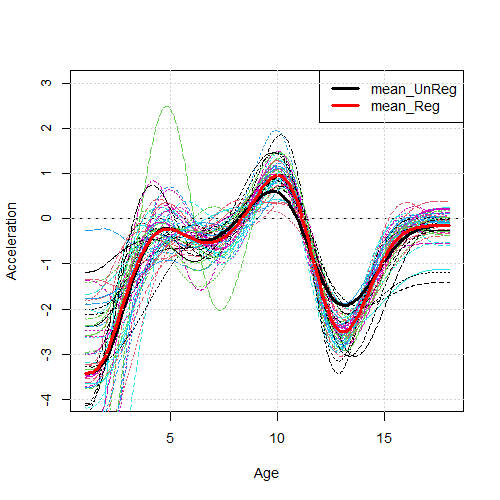

In [67]:
regList = register.fd(yfd=accelUnreg)
accelReg = regList$regfd
mean_accelReg = mean.fd(accelReg)
# $regfd extracts the registered functions

pngname=paste0("./images/232_growth_accel_reg.png")
png(pngname, width=500, height = 500)
par(cex=1.2)

plot(accelReg, xlab="Age", ylab="Acceleration", ylim=c(-4,3))
lines(mean_accelUnreg, lwd=3, col="black")
lines(mean_accelReg, lwd=3, col="red")
legend("topright", legend=c("mean_UnReg", "mean_Reg"), lty=c(1,1),  lwd=c(3,3), col=c("black", "red"))

grid()

dev.off()
png_data <- readBin(pngname, "raw", file.size(pngname))
display_png(png_data)

In [26]:
warpFunctions = regList$warpfd
# $warpfd extracts the warping functions

APList = AmpPhaseDecomp(xfd=accelUnreg, yfd=accelReg, hfd=warpFunctions)

APList$RSQR
APList$MS.amp
APList$MS.pha

[1] 0.3900564

[1] 5.917822

[1] 3.784422